In [1]:
%matplotlib inline
import torch
import torchvision
import torch.nn as nn
import matplotlib
from torch.utils import data
import matplotlib.pyplot as plt
from torchvision import transforms
from d2l import torch as d2l
import numpy as np
from IPython import display


d2l.use_svg_display()
torch.manual_seed(666)

In [2]:
def show_images(X, titles):
    fig, axes = plt.subplots(2, 9, figsize=(13, 5))
    axes = axes.flatten()

    for ax, img, label in zip(axes, X, titles):
        ax.imshow(img.numpy(), cmap='Blues')
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        ax.set_title(label)

In [3]:
def load_data_fashion_mnist(batch_size, resize=None):
    """Download the Fashion-MNIST dataset and then load it into memory."""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root="./data",
                                                    train=True,
                                                    transform=trans,
                                                    download=True)
    mnist_test = torchvision.datasets.FashionMNIST(root="./data",
                                                   train=False,
                                                   transform=trans,
                                                   download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=False,
                            num_workers=4),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=4))

In [4]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(dim=1, keepdim=True)
    return X_exp / partition


def cross_entropy(y_hat, y):
    return -torch.log(y_hat[range(len(y)), y])



def accuracy(y_hat, y):
    y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.sum())

In [5]:
def dev(net, dv_set, loss):
    if isinstance(net, torch.nn.Module):
        net.eval()
    
    metric = torch.zeros(3)

    for X, y in dv_set:
        y_hat = net(X)
        metric += torch.tensor([loss(y_hat, y) * len(y), accuracy(y_hat, y),  y.numel()])
    
    return float(metric[0] / metric[2]), float(metric[1] / metric[2])


In [6]:
config = {
    "in": 784,
    "out": 10,
    "batch_size": 256,
    "lr": 0.03,
    "epochs": 10,
    "optimizer": "SGD",
    "optim_hparas": {
        'lr': 0.1
    }
}

In [7]:
class SoftmaxReg(nn.Module):
    def __init__(self, m_features, n_labels):
        super().__init__()
        
        self.net = nn.Sequential(nn.Flatten(), nn.Linear(m_features, n_labels))
        
        def init_weights(m):
            if type(m) == nn.Linear:
                nn.init.normal_(m.weight, std=0.01)

        self.net.apply(init_weights)

    def forward(self, X):
        return self.net(X)


In [8]:
def net(X):
    return softmax(X.reshape(-1, W.shape[0]) @ W + b)

In [9]:
W = torch.normal(0, 0.01, size=(config["in"], config["out"]), requires_grad=True)
b = torch.zeros(config["out"], requires_grad=True)

In [10]:
tr_set, te_set = load_data_fashion_mnist(batch_size=config["batch_size"])

/root/miniconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [11]:
def train(model, tr_set, te_set, loss):
    epochs = config["epochs"]

    optimizer = getattr(torch.optim, config["optimizer"])(
        model.parameters(), **config["optim_hparas"]
    )

    epoch = 0

    loss_record = {"train": [], "dev": []}

    animator = d2l.Animator(xlabel='epoch', xlim=[1, epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test loss', 'test acc'])

    while epoch < epochs:
        model.train()
        for X_sample, y_sample in tr_set:
            optimizer.zero_grad()
            l = loss(model(X_sample), y_sample)
            l.backward()
            optimizer.step()
            
            # loss_record['train'].append(l.detach().item())

        epoch += 1
        
        with torch.no_grad():

            train_l, train_acc = dev(model, tr_set, loss)
            dev_l, dev_acc = dev(model, te_set, loss)
            animator.add(epoch, (train_l, train_acc, dev_l, dev_acc))
#             print(f"epoch: {epoch:3d}, train loss: {train_l: .4f}, dev loss: {dev_l:.4f}")

(0.4402993619441986, 0.850600004196167)


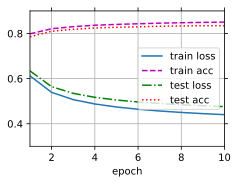

In [12]:
loss = nn.CrossEntropyLoss()
model = SoftmaxReg(config["in"], config["out"])
train(model, tr_set, te_set, loss)

with torch.no_grad():
    print(dev(model, tr_set, loss))


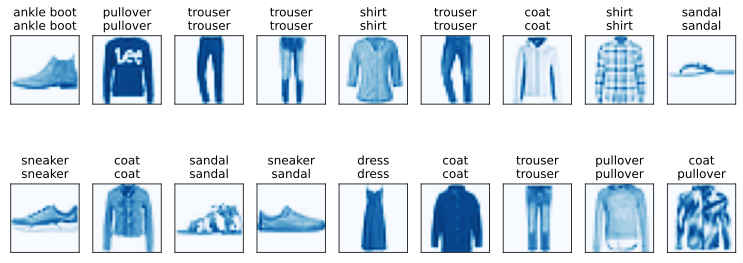

In [13]:
for X, y in te_set:
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(model(X).argmax(axis=1))
    titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
    show_images(X[:18].reshape(18, 28, 28), titles)
    break

In [14]:
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])